#  User Login Logs Clustering and Analysis

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy  import dendrogram,linkage


import warnings
warnings.filterwarnings("ignore")

## Generating Random User Login Logs Dataset

- User ID
- Login Hours
- IP Variety
- Successful Logins

In real life, we may have to create the data set ourselves.


In [53]:
np.random.seed(42)
num_users = 1000
# Normal (Gaussian) 
data = {
    "User_ID": np.arange(1, num_users + 1),
    "Login_Hours": np.clip(np.random.normal(loc=12, scale=4, size=num_users), 0, 23),  # Mean=12, Std=4
    # Şüpheliler daha fazla IP kullanabilir
    "IP_Variety": np.clip(np.random.normal(loc=5, scale=2, size=num_users), 1, 10),  # Mean=5, Std=2
    "Successful_Logins": np.clip(np.random.normal(loc=5, scale=3, size=num_users), 1, 20),  # Mean=25, Std=10
}

df = pd.DataFrame(data) 
# df.to_csv("user_login_data.csv", index=False)

In [54]:
df.head()

,User_ID,Login_Hours,IP_Variety,Successful_Logins
0,1,13.986857,7.798711,2.974465
1,2,11.446943,6.849267,4.566444
2,3,14.590754,5.119261,2.622740
3,4,18.092119,3.706126,4.076115
4,5,11.063387,6.396447,1.000000


## Data Analysis

In [55]:
df.describe()

,User_ID,Login_Hours,IP_Variety,Successful_Logins
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,12.072567,5.156128,5.130237
std,288.819436,3.895010,1.940676,2.740688
min,1.000000,0.000000,1.000000,1.000000
25%,250.750000,9.409639,3.787517,3.056001
50%,500.500000,12.101202,5.126154,4.999248
75%,750.250000,14.591776,6.457764,6.982746
max,1000.000000,23.000000,10.000000,16.778713


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   User_ID            1000 non-null   int32  
 1   Login_Hours        1000 non-null   float64
 2   IP_Variety         1000 non-null   float64
 3   Successful_Logins  1000 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 27.5 KB


### Features Distribution

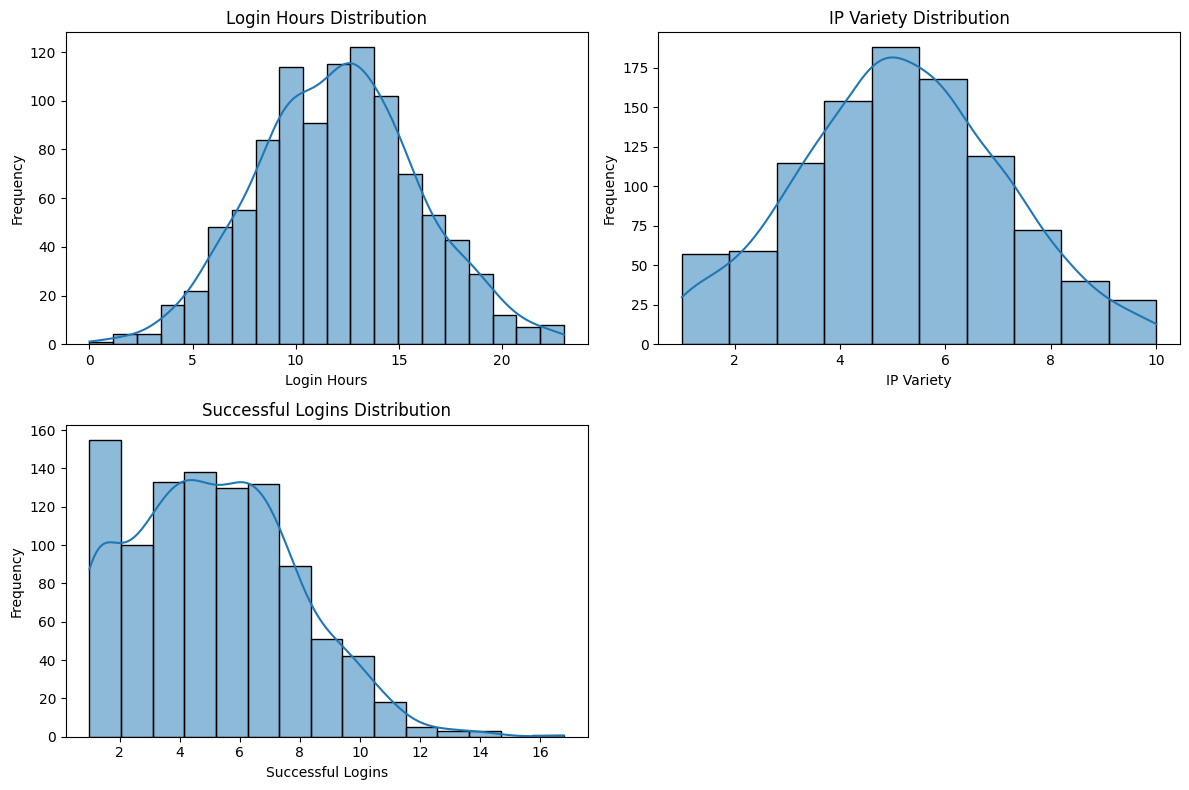

In [57]:
plt.figure(figsize=(12, 8))

# Login Hours 
plt.subplot(2, 2, 1)
sns.histplot(df["Login_Hours"], bins=20, kde=True)
plt.title("Login Hours Distribution")
plt.xlabel("Login Hours")
plt.ylabel("Frequency")

# IP Variety 
plt.subplot(2, 2, 2)
sns.histplot(df["IP_Variety"], bins=10, kde=True)
plt.title("IP Variety Distribution")
plt.xlabel("IP Variety")
plt.ylabel("Frequency")

# Successful Logins 
plt.subplot(2, 2, 3)
sns.histplot(df["Successful_Logins"], bins=15, kde=True)
plt.title("Successful Logins Distribution")
plt.xlabel("Successful Logins")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

### Correlation Analysis

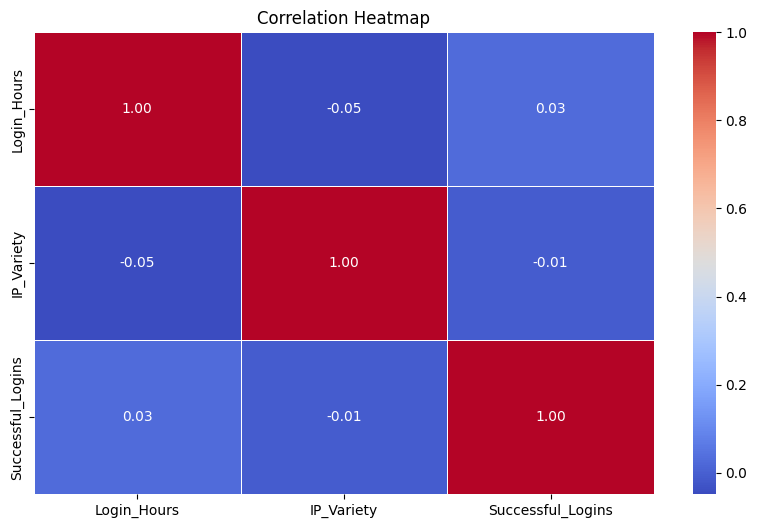

In [58]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["User_ID"]).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

* Değişkenler arasında anlamlı bir korelasyon yok.

## Determining the Optimal Number of Clusters : Elbow
*  WCSS (Within-Cluster Sum of Squares), her bir veri noktasının küme merkezine olan uzaklıklarının karelerinin toplamıdır.

In [65]:
wcss = [] # Within-cluster Sum of Squares
for i in range(1, 11):  
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)  

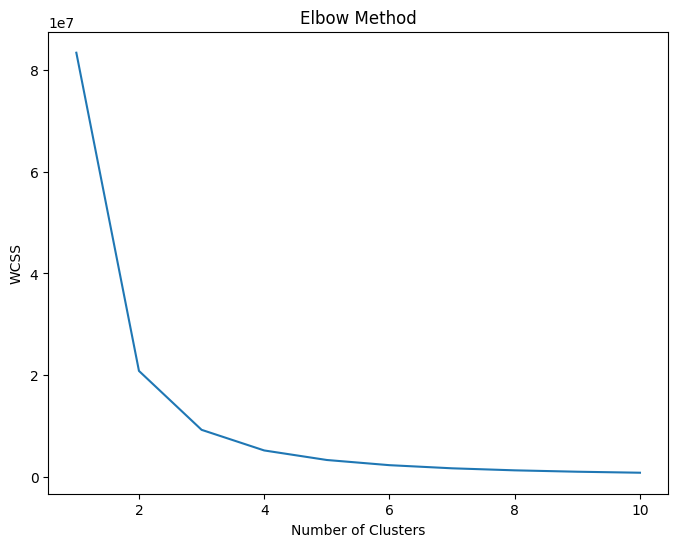

In [67]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**k = 3 veya k = 4**

## Clustering Modeling : Unspervised learning (GMM)

In [69]:
X = df[["Login_Hours", "IP_Variety", "Successful_Logins"]].values

In [70]:
X[:5]

array([[13.98685661,  7.79871087,  2.97446518],
       [11.4469428 ,  6.84926737,  4.56644399],
       [14.59075415,  5.11926074,  2.62274024],
       [18.09211943,  3.70612644,  4.07611541],
       [11.0633865 ,  6.39644663,  1.        ]])

### Gaussian Mixture Model

In [74]:
gmm = GaussianMixture(n_components=4, random_state=42)  
df["Cluster"] = gmm.fit_predict(X)

In [82]:
df.tail(10)

,User_ID,Login_Hours,IP_Variety,Successful_Logins,Cluster
990,991,12.833531,6.600819,9.549182,2
991,992,3.833061,6.508583,6.806355,3
992,993,11.011290,7.377827,5.216111,2
993,994,9.272063,6.416608,4.363373,3
994,995,7.993520,5.702896,2.144245,3
995,996,10.875599,7.140300,5.232442,2
996,997,19.190746,4.946957,5.773258,1
997,998,14.563371,3.236251,1.274718,0
998,999,9.715284,4.673866,6.002529,2
999,1000,14.290331,3.510195,4.534223,0


**GMM modelinde, her veri noktası tüm kümelere belirli bir olasılıkla ait olabilir.**

In [84]:
probabilities = gmm.predict_proba(X)
probabilities

array([[0.77677034, 0.04807456, 0.14937892, 0.02577617],
       [0.49281986, 0.0129279 , 0.31512275, 0.17912949],
       [0.82208647, 0.07402513, 0.0925709 , 0.0113175 ],
       ...,
       [0.90898736, 0.05178825, 0.03087728, 0.00834711],
       [0.08970114, 0.00661809, 0.47513656, 0.42854421],
       [0.40994514, 0.16234226, 0.40905327, 0.01865933]])

In [85]:
probabilities.shape

(1000, 4)

## Visualisation with T-SNE (t-Distributed Stochastic Neighbor Embedding)

* T-SNE , veri kümelerinin görselleştirilmesi için kullanılan bir boyut azaltma tekniğidir.

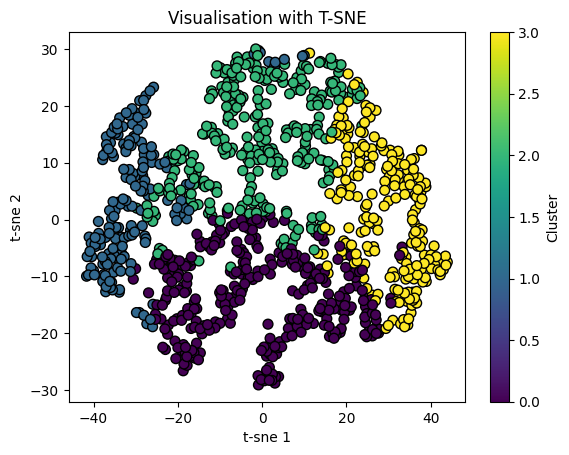

In [79]:
tsne = TSNE(n_components=2,random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure()
plt.scatter(x=X_tsne[:,0],y=X_tsne[:,1],
            c=df["Cluster"],cmap="viridis",marker="o",edgecolors="k",s=50)
plt.title("Visualisation with T-SNE")
plt.ylabel("t-sne 2")
plt.xlabel("t-sne 1")
plt.colorbar(label="Cluster")
plt.show()

## Hierarchical Clustering : Dendrogram

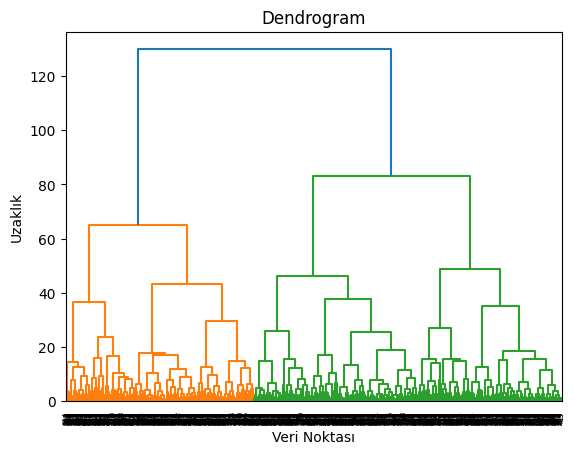

In [80]:
linkage_matrix=linkage(X,method="ward")
plt.figure()
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Veri Noktası")
plt.ylabel("Uzaklık")
plt.show()